<p><font size="6"><b> Basis Raster operaties en raster-vector tools</b></font></p>

> *GCCA+ phase 2 - Geopyhton training*  
> *June, 2023*
>
> *© 2023, Jasper Feyen  (<mailto:jasperfeyen@hotmail.com>)*

---
---

In het vorige notebook focusten we enkel op vectoren of raster. Uiteraard kunnen we veel meer indien we vectoren en rasters kunnen combinerenç

In [1]:
import pandas as pd
import numpy as np
import geopandas
import rasterio

import xarray as xr

import matplotlib.pyplot as plt

C:\Users\jaspe\AppData\Local\Temp\ipykernel_21448\4205478012.py:3: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas


# `rioxarray`: de kracht van xarray en rasterio samen

In de vorige notebooks hebben we al gebruik gemaakt van `rasterio` (https://rasterio.readthedocs.io/en/latest/) om rasterbestanden zoals GeoTIFFs te lezen (via de `xarray.open_dataarray(...,engine="rasterio")` functie). Rasterio biedt ondersteuning voor het lezen en schrijven van georuimtelijke rastergegevens als numpy N-D arrays, voornamelijk via bindings met de GDAL-library.

Daarnaast biedt rasterio een Python API om enkele GIS-rasterbewerkingen uit te voeren (clipping, masking, warping, samenvoegen, transformatie, enz.) en kan het worden gebruikt om slechts een subset van een groot dataset in het geheugen te laden. De belangrijkste complexiteit bij het gebruik van `rasterio` is echter dat de ruimtelijke informatie losgekoppeld is van de gegevens zelf (d.w.z. de numpy-array). Dit betekent dat je de omvang en metadata gedurende de bewerkingen moet bijhouden en organiseren (bijv. de "transform") en dat je moet bijhouden wat elke dimensie vertegenwoordigt (y-eerst, aangezien arrays eerst georganiseerd zijn langs rijen). 

Maak kennis met `rioxarray` (https://corteva.github.io/rioxarray/stable/index.html), dat xarray uitbreidt met georuimtelijke functionaliteiten aangedreven door rasterio.


In [2]:
import rioxarray

In [78]:
data_file = "data/Sentinel_2022_example.tif"

In [79]:
data = rioxarray.open_rasterio(data_file)
data

<xarray.DataArray (band: 10, y: 583, x: 841)>
[4903030 values with dtype=float64]
Coordinates:
  * band         (band) int32 1 2 3 4 5 6 7 8 9 10
  * x            (x) float64 6.918e+05 6.919e+05 6.919e+05 ... 7.17e+05 7.17e+05
  * y            (y) float64 6.629e+05 6.629e+05 ... 6.455e+05 6.454e+05
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        5478
    STATISTICS_MEAN:           472.7046585859
    STATISTICS_MINIMUM:        115
    STATISTICS_STDDEV:         257.30237609214
    STATISTICS_VALID_PERCENT:  99.36
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 ('B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8...

De `rioxarray.open_rasterio` functie is vergelijkbaar met `xarray.open_dataarray`.

Zodra `rioxarray` is geïmporteerd, biedt het een `.rio` accessor op het `xarray.DataArray` object, waarmee toegang wordt verkregen tot enkele eigenschappen van de rastergegevens:

In [80]:
data.rio.crs

CRS.from_epsg(32621)

In [81]:
data.rio.bounds()

(691830.0, 645420.0, 717060.0, 662910.0)

In [82]:
data.rio.resolution()

(30.0, -30.0)

In [83]:
data.rio.nodata

In [84]:
data.rio.transform()

Affine(30.0, 0.0, 691830.0,
       0.0, -30.0, 662910.0)

## Bandnamen hernoemen

Bij het bekijken van de raster dataset, hebben we de 10 verschillende Sentinel-2 banden, deze zijn genummerd van 1 tot 10. Dit komt niet overeen met de werkelijke bandnummer van Sentinel-2 zoals die moet gegeven zijn.

Zo is onze band 1 de blauwe band, wat volgens Sentinel-2 benaming eigenlijk "Band 2" moet zijn. Zo klopt voor elk van onze banden het gegeven bandnummer niet met de bandbenamingen. Kijken we onder de 'Attributes', zien we echter wel dat de 'long name' als metadata zit opgeslagen: de werkelijke bandnamen.

Het zou dus handig zijn om deze labels toe te kennen aan onze banden, om verwarring te voorkomen. Gelukkig kan dit!

In [93]:
# Bandnamen zitten opgeslagen onder de attributen
data.attrs['long_name']

('B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12')

We kunnen de labels toekennen met assign_coordinates:

In [96]:
data = data.assign_coords(band=("band", list(data.attrs['long_name'])))
data

<xarray.DataArray (band: 10, y: 583, x: 841)>
[4903030 values with dtype=float64]
Coordinates:
  * band         (band) <U3 'B2' 'B3' 'B4' 'B5' 'B6' 'B7' 'B8' 'B8A' 'B11' 'B12'
  * x            (x) float64 6.918e+05 6.919e+05 6.919e+05 ... 7.17e+05 7.17e+05
  * y            (y) float64 6.629e+05 6.629e+05 ... 6.455e+05 6.454e+05
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        5478
    STATISTICS_MEAN:           472.7046585859
    STATISTICS_MINIMUM:        115
    STATISTICS_STDDEV:         257.30237609214
    STATISTICS_VALID_PERCENT:  99.36
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 ('B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8...

## Reprojecting rasters

`rioxarray` geeft toegang tot een set rasterverwerkingsfuncties van rasterio/GDAL.

Een daarvan is het herschalen (transformeren en resampling) van rasters, bijvoorbeeld om naar een ander coördinatenreferentiesysteem te transformeren, naar een andere resolutie te verkleinen/vergroten, enzovoort. In al deze gevallen, bij de transformatie van een oorspronkelijk raster naar een doelraster, moeten pixelwaarden opnieuw worden berekend. Er zijn verschillende "resampling"methoden die hiervoor kunnen worden gebruikt: de Nearest Neighbor pixelwaarde, het gemiddelde berekenen, een (niet-)lineaire interpolatie, enzovoort..

De functionaliteit is beschikbaar via de `reproject()`-methode.:


In [98]:
#We nemen enkel de rode, groene en blauwe band (= B4, B3, B2)
data.sel(band = ['B4','B3','B2']).rio.crs

CRS.from_epsg(32621)

C:\Users\jaspe\anaconda3\envs\GCCA-Geopython\lib\site-packages\matplotlib\cm.py:440: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


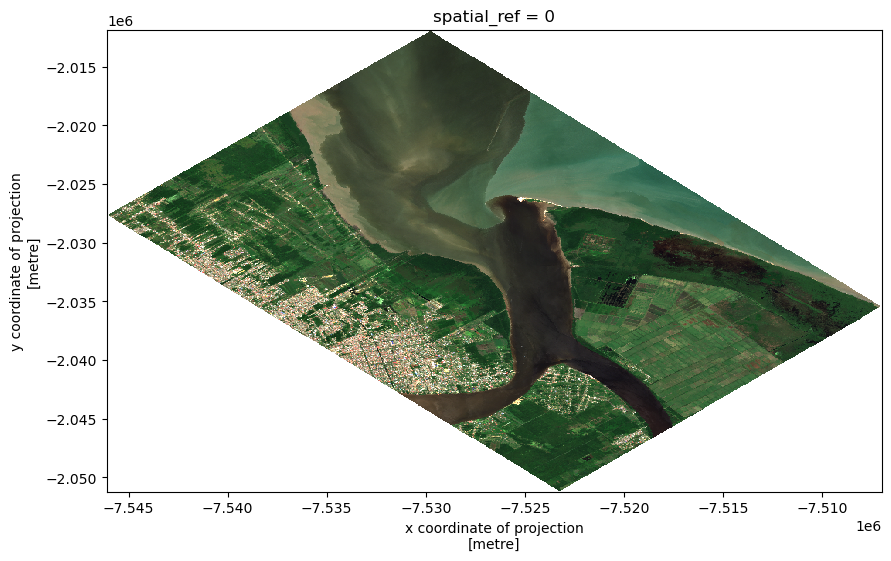

In [99]:
data.sel(band = ['B4','B3','B2']).rio.reproject("EPSG:31370").plot.imshow(figsize=(10,6),vmax=0.2)

De *default* resampling methode  is "nearest", wat vaak geen geschikte methode is (vooral voor continue data). We kunnen de methode wijzigen met behulp van de `rasterio.enums.Resampling`-enumeratie (zie [docs](https://rasterio.readthedocs.io/en/latest/api/rasterio.enums.html#rasterio.enums.Resampling) voor een overzicht van alle methoden):

In [100]:
from rasterio.enums import Resampling

C:\Users\jaspe\anaconda3\envs\GCCA-Geopython\lib\site-packages\matplotlib\cm.py:440: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


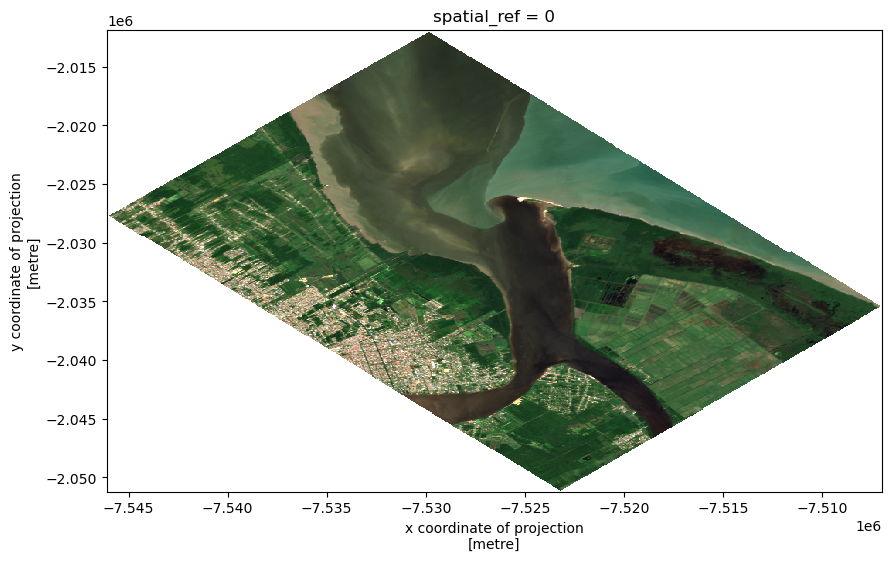

In [102]:
data.rio.reproject("EPSG:31370", resampling=Resampling.bilinear).sel(band=['B4','B3','B2']).plot.imshow(figsize=(10,6),vmax = 0.2)

Je kunt ook meteen downsamplen

C:\Users\jaspe\anaconda3\envs\GCCA-Geopython\lib\site-packages\matplotlib\cm.py:440: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


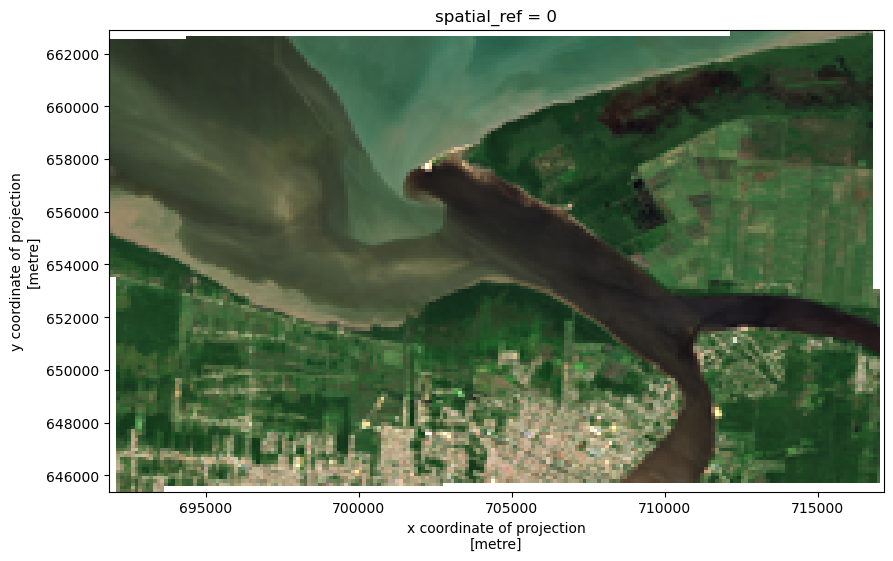

In [103]:
data.rio.reproject(data.rio.crs, resolution=120, resampling=Resampling.cubic).sel(band=['B4','B3','B2']).plot.imshow(figsize=(10,6),vmax = 0.2)

# Clip raster by mask layer

Binnen veel toepassingen is het studiegebied (veel) kleiner dan de gegeven rasters.

In [39]:
districts = geopandas.read_file("./data/Suriname_districts.geojson")
paramaribo_district = districts[districts['DISTR_NAAM'] == 'Paramaribo']
paramaribo_district

,DISTR_NAAM,geometry
6,Paramaribo,"MULTIPOLYGON (((-55.09344 5.88945, -55.09347 5..."


<AxesSubplot:>

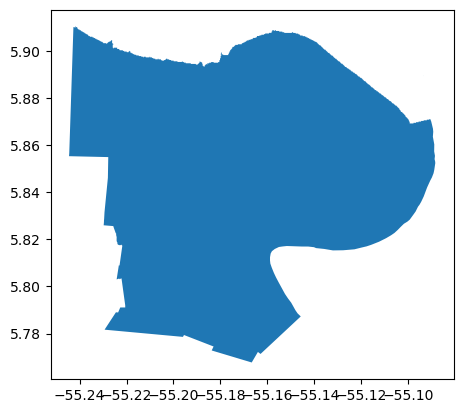

In [40]:
paramaribo_district.plot()

In [43]:
paramaribo_district.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We moeten zorgen dat beide datasets in hetzelfde CRS staan!

In [105]:
paramaribo_district = paramaribo_district.to_crs(epsg=32621)

In [106]:
clipped = data.rio.clip(paramaribo_district.geometry)

C:\Users\jaspe\anaconda3\envs\GCCA-Geopython\lib\site-packages\matplotlib\cm.py:440: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
C:\Users\jaspe\anaconda3\envs\GCCA-Geopython\lib\site-packages\matplotlib\cm.py:440: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


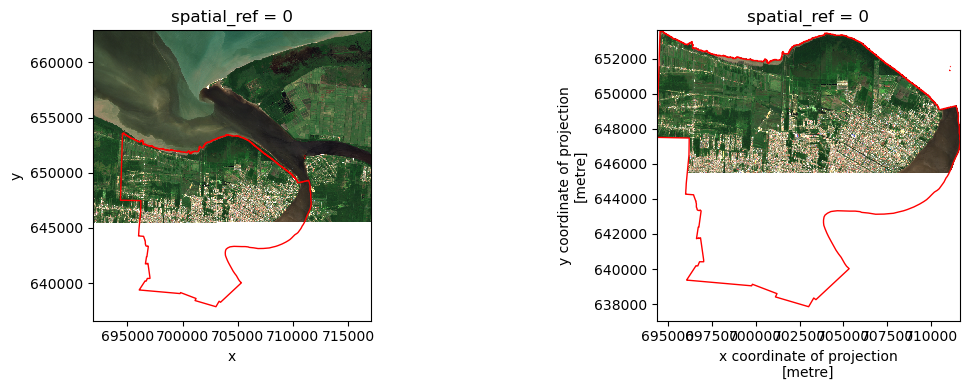

In [107]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12,4))
data.sel(band=['B4','B3','B2']).plot.imshow(ax=ax0, vmax = 0.2)
paramaribo_district.plot(ax=ax0, facecolor="none", edgecolor="red")

clipped.sel(band=['B4','B3','B2']).plot.imshow(ax=ax1, vmax = 0.2)
paramaribo_district.plot(ax=ax1, facecolor="none", edgecolor="red")

fig.tight_layout()

De bovenstaande code maakt gebruik van het `rasterio`-pakket (met de functionaliteit `mask` en `geometry_mask` / `rasterize`) onder de motorkap. Dit vereenvoudigt de bewerking in vergelijking met het direct gebruik van `rasterio`.

```python
   # cfr. The Rasterio workflow

   from rasterio.mask import mask

   # 1 - Open een dataset met behulp van de contextbeheerder
   with rasterio.open(data_file) as src:

    # 2 - Lees de dataset en transformeer deze door uit te snijden
    out_image, out_transform = mask(src, paramaribo_vect.geometry, crop=True)

    # 3 - Werk de ruimtelijke metadata/profiel van de dataset bij
    paramaribo_profile = src.profile
    paramaribo_profile.update({"height": out_image.shape[1],
                              "width": out_image.shape[2],
                              "transform": out_transform})
    # 4 - Sla de nieuwe dataset op met de bijgewerkte metadata/profiel
    with rasterio.open("./paramaribo_masked.tif", "w", **paramaribo_profile) as dest:
        dest.write(out_image)



# Raster bewerkingen

## Reducties & element-gewijze berekeningen

In [135]:
paramaribo = xr.open_dataarray( "data/Sentinel_2022_example.tif", engine="rasterio")
paramaribo = paramaribo.assign_coords(band=("band", list(paramaribo.attrs['long_name'])))
paramaribo_red = paramaribo.sel(band="B4")

### Reducties

De __reductie__ (aggregaties) worden aangeboden als methoden en kunnen worden toegepast langs één of meerdere dimensies van de gegevens.

Standaard wordt een array gereduceerd over *alle* dimensies, waarbij een enkele waarde als ouput wordt gegeven als een DataArray:

In [136]:
paramaribo_red.mean()

<xarray.DataArray 'band_data' ()>
array(0.05395728)
Coordinates:
    band         <U3 'B4'
    spatial_ref  int32 ...

In NumPy, deze dimenties worden __axis__ genoemd:

In [137]:
paramaribo_red.mean(axis=1)

<xarray.DataArray 'band_data' (y: 583)>
array([0.08889882, 0.05954411, 0.05320308, 0.05140739, 0.05074756,
       0.05022151, 0.04987914, 0.04986287, 0.04936317, 0.04907539,
       0.04879023, 0.04896847, 0.04894368, 0.04873242, 0.04834315,
       0.04822616, 0.04786794, 0.04739428, 0.04680495, 0.04654035,
       0.04642807, 0.04580477, 0.04493766, 0.0448357 , 0.04454726,
       0.04454172, 0.04435638, 0.04427622, 0.04416621, 0.04416001,
       0.04425101, 0.04430691, 0.04385036, 0.04373021, 0.04347187,
       0.04354917, 0.04438268, 0.04428542, 0.04426893, 0.04398869,
       0.04346429, 0.04355405, 0.04353131, 0.04332286, 0.04342958,
       0.04320762, 0.04342381, 0.04355012, 0.04430482, 0.04430821,
       0.04450577, 0.0445078 , 0.04440012, 0.04444238, 0.04396667,
       0.04346149, 0.04385899, 0.04375381, 0.0434372 , 0.04371679,
       0.04371185, 0.04382274, 0.04456315, 0.04479702, 0.04467036,
       0.04448625, 0.04424798, 0.04403857, 0.04384185, 0.04383292,
       0.04442452, 0.04465089, 0.04500798, 0.04492048, 0.04520411,
       0.0452003 , 0.04489952, 0.04505321, 0.04539571, 0.04539756,
       0.04545792, 0.04573036, 0.04523649, 0.04475851, 0.04464625,
       0.04460149, 0.04426893, 0.04407512, 0.04447964, 0.04470661,
       0.04622929, 0.04582476, 0.04381565, 0.04363637, 0.04383607,
       0.04364881, 0.04392923, 0.04398946, 0.04378792, 0.04388363,
...
       0.06642315, 0.06092357, 0.06226429, 0.06554768, 0.065015  ,
       0.06457202, 0.06719119, 0.06375601, 0.06491875, 0.06407887,
       0.06441833, 0.06437161, 0.06593113, 0.06583423, 0.0632803 ,
       0.06427125, 0.06623095, 0.06492339, 0.06649726, 0.06640946,
       0.06989065, 0.07153875, 0.06891417, 0.06973238, 0.07367583,
       0.07537113, 0.0741953 , 0.07515964, 0.07158857, 0.06930244,
       0.07074107, 0.07147268, 0.07315012, 0.07439179, 0.07547024,
       0.07705774, 0.07785982, 0.07535958, 0.07284417, 0.07148256,
       0.07068827, 0.07568024, 0.07772631, 0.07674619, 0.07838518,
       0.0795756 , 0.08152542, 0.08236702, 0.08356827, 0.08388923,
       0.08680077, 0.08800399, 0.08758488, 0.08470065, 0.08647429,
       0.08660887, 0.09029673, 0.08964774, 0.08871292, 0.08676774,
       0.08590893, 0.0887278 , 0.08816244, 0.08674137, 0.08564893,
       0.0880378 , 0.08889304, 0.08950607, 0.09137762, 0.08955274,
       0.09028958, 0.09007298, 0.08728393, 0.08837512, 0.0876056 ,
       0.0876531 , 0.08763798, 0.08900107, 0.08999018, 0.08994875,
       0.09159833, 0.08836792, 0.0881731 , 0.08788077, 0.08732744,
       0.08580304, 0.08634565, 0.08715458, 0.08806857, 0.08851321,
       0.09194833, 0.09226619, 0.09227643, 0.09269292, 0.09095839,
       0.10354867, 0.10682272, 0.08298358])
Coordinates:
    band         <U3 'B4'
  * y            (y) float64 6.629e+05 6.629e+05 ... 6.455e+05 6.454e+05
    spatial_ref  int32 ...

Maar we hebben dimensies met labels (zoals 'X', en 'Y'), dus in plaats van reducties uit te voeren op assen (zoals in NumPy), kunnen we ze uitvoeren op de dimensies (x of y as). Dit is handiger:

In [138]:
paramaribo_red.mean(dim="x")

<xarray.DataArray 'band_data' (y: 583)>
array([0.08889882, 0.05954411, 0.05320308, 0.05140739, 0.05074756,
       0.05022151, 0.04987914, 0.04986287, 0.04936317, 0.04907539,
       0.04879023, 0.04896847, 0.04894368, 0.04873242, 0.04834315,
       0.04822616, 0.04786794, 0.04739428, 0.04680495, 0.04654035,
       0.04642807, 0.04580477, 0.04493766, 0.0448357 , 0.04454726,
       0.04454172, 0.04435638, 0.04427622, 0.04416621, 0.04416001,
       0.04425101, 0.04430691, 0.04385036, 0.04373021, 0.04347187,
       0.04354917, 0.04438268, 0.04428542, 0.04426893, 0.04398869,
       0.04346429, 0.04355405, 0.04353131, 0.04332286, 0.04342958,
       0.04320762, 0.04342381, 0.04355012, 0.04430482, 0.04430821,
       0.04450577, 0.0445078 , 0.04440012, 0.04444238, 0.04396667,
       0.04346149, 0.04385899, 0.04375381, 0.0434372 , 0.04371679,
       0.04371185, 0.04382274, 0.04456315, 0.04479702, 0.04467036,
       0.04448625, 0.04424798, 0.04403857, 0.04384185, 0.04383292,
       0.04442452, 0.04465089, 0.04500798, 0.04492048, 0.04520411,
       0.0452003 , 0.04489952, 0.04505321, 0.04539571, 0.04539756,
       0.04545792, 0.04573036, 0.04523649, 0.04475851, 0.04464625,
       0.04460149, 0.04426893, 0.04407512, 0.04447964, 0.04470661,
       0.04622929, 0.04582476, 0.04381565, 0.04363637, 0.04383607,
       0.04364881, 0.04392923, 0.04398946, 0.04378792, 0.04388363,
...
       0.06642315, 0.06092357, 0.06226429, 0.06554768, 0.065015  ,
       0.06457202, 0.06719119, 0.06375601, 0.06491875, 0.06407887,
       0.06441833, 0.06437161, 0.06593113, 0.06583423, 0.0632803 ,
       0.06427125, 0.06623095, 0.06492339, 0.06649726, 0.06640946,
       0.06989065, 0.07153875, 0.06891417, 0.06973238, 0.07367583,
       0.07537113, 0.0741953 , 0.07515964, 0.07158857, 0.06930244,
       0.07074107, 0.07147268, 0.07315012, 0.07439179, 0.07547024,
       0.07705774, 0.07785982, 0.07535958, 0.07284417, 0.07148256,
       0.07068827, 0.07568024, 0.07772631, 0.07674619, 0.07838518,
       0.0795756 , 0.08152542, 0.08236702, 0.08356827, 0.08388923,
       0.08680077, 0.08800399, 0.08758488, 0.08470065, 0.08647429,
       0.08660887, 0.09029673, 0.08964774, 0.08871292, 0.08676774,
       0.08590893, 0.0887278 , 0.08816244, 0.08674137, 0.08564893,
       0.0880378 , 0.08889304, 0.08950607, 0.09137762, 0.08955274,
       0.09028958, 0.09007298, 0.08728393, 0.08837512, 0.0876056 ,
       0.0876531 , 0.08763798, 0.08900107, 0.08999018, 0.08994875,
       0.09159833, 0.08836792, 0.0881731 , 0.08788077, 0.08732744,
       0.08580304, 0.08634565, 0.08715458, 0.08806857, 0.08851321,
       0.09194833, 0.09226619, 0.09227643, 0.09269292, 0.09095839,
       0.10354867, 0.10682272, 0.08298358])
Coordinates:
    band         <U3 'B4'
  * y            (y) float64 6.629e+05 6.629e+05 ... 6.455e+05 6.454e+05
    spatial_ref  int32 ...

Berekenen van gemiddelde per as

In [139]:
paramaribo.mean(dim=["x", "y"])  #  'neem het gemiddelde over de x- en y- as samen)

<xarray.DataArray 'band_data' (band: 10)>
array([0.04727047, 0.06985983, 0.05395728, 0.08861957, 0.16363052,
       0.19462845, 0.19038938, 0.20402165, 0.11366248, 0.06526632])
Coordinates:
  * band         (band) <U3 'B2' 'B3' 'B4' 'B5' 'B6' 'B7' 'B8' 'B8A' 'B11' 'B12'
    spatial_ref  int32 ...

### Elementsgewijze berekeningen

In Xarray kun je gemakkelijk elementswijze berekingen uitvoeren. In onderstaand voorbeeld vermenigvuldig je dus **elke** pixel in de rode band met 10

In [140]:
paramaribo_red * 10.

<xarray.DataArray 'band_data' (y: 583, x: 841)>
array([[  nan,   nan,   nan, ..., 1.139,   nan,   nan],
       [  nan,   nan,   nan, ..., 1.133,   nan,   nan],
       [  nan,   nan,   nan, ..., 1.073,   nan,   nan],
       ...,
       [  nan, 0.491, 0.415, ...,   nan,   nan,   nan],
       [  nan, 0.579, 0.721, ...,   nan,   nan,   nan],
       [  nan, 0.632, 0.488, ...,   nan,   nan,   nan]])
Coordinates:
    band         <U3 'B4'
  * x            (x) float64 6.918e+05 6.919e+05 6.919e+05 ... 7.17e+05 7.17e+05
  * y            (y) float64 6.629e+05 6.629e+05 ... 6.455e+05 6.454e+05
    spatial_ref  int32 ...

Indien we meerdere banden met elkaar combineren, gebeurt ook dit elementgewijs; 

In [141]:
paramaribo.sel(band="B4") - paramaribo.sel(band="B3")

<xarray.DataArray 'band_data' (y: 583, x: 841)>
array([[    nan,     nan,     nan, ...,  0.0057,     nan,     nan],
       [    nan,     nan,     nan, ...,  0.0074,     nan,     nan],
       [    nan,     nan,     nan, ...,  0.008 ,     nan,     nan],
       ...,
       [    nan, -0.0178, -0.0235, ...,     nan,     nan,     nan],
       [    nan, -0.0192, -0.0068, ...,     nan,     nan,     nan],
       [    nan, -0.016 , -0.0187, ...,     nan,     nan,     nan]])
Coordinates:
  * x            (x) float64 6.918e+05 6.919e+05 6.919e+05 ... 7.17e+05 7.17e+05
  * y            (y) float64 6.629e+05 6.629e+05 ... 6.455e+05 6.454e+05
    spatial_ref  int32 0

### Oefenen dan maar!

<div class="alert alert-success">

**OEFENING**:

Op basis van onze verschillende banden in het Sentinel-beeld, kunnen we de NDVI berekenen. Deze wordt berekend op basis van band 8 en band 4:
    
$$\frac{band_8 - band_4}{band_8 + band_4} $$
    
Maak gebruik van de Paramaribo-set:
    
- Zorg er eerst voor dat de verschillende banden hun correcte naam meekrijgen. 
- Bereken de NDVI, sla deze op als een nieuwe variabele: paramaribo_ndvi
- Maak een visualitie. Gebruik "Greens" als colormap. 


           
</div>

In [143]:
paramaribo

<xarray.DataArray 'band_data' (band: 10, y: 583, x: 841)>
array([[[   nan,    nan, ...,    nan,    nan],
        [   nan,    nan, ...,    nan,    nan],
        ...,
        [   nan, 0.0439, ...,    nan,    nan],
        [   nan, 0.0454, ...,    nan,    nan]],

       [[   nan,    nan, ...,    nan,    nan],
        [   nan,    nan, ...,    nan,    nan],
        ...,
        [   nan, 0.0771, ...,    nan,    nan],
        [   nan, 0.0792, ...,    nan,    nan]],

       ...,

       [[   nan,    nan, ...,    nan,    nan],
        [   nan,    nan, ...,    nan,    nan],
        ...,
        [   nan, 0.2188, ...,    nan,    nan],
        [   nan, 0.2308, ...,    nan,    nan]],

       [[   nan,    nan, ...,    nan,    nan],
        [   nan,    nan, ...,    nan,    nan],
        ...,
        [   nan, 0.1221, ...,    nan,    nan],
        [   nan, 0.1269, ...,    nan,    nan]]])
Coordinates:
  * band         (band) <U3 'B2' 'B3' 'B4' 'B5' 'B6' 'B7' 'B8' 'B8A' 'B11' 'B12'
  * x            (x) float64 6.918e+05 6.919e+05 6.919e+05 ... 7.17e+05 7.17e+05
  * y            (y) float64 6.629e+05 6.629e+05 ... 6.455e+05 6.454e+05
    spatial_ref  int32 ...
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        5478
    STATISTICS_MEAN:           472.7046585859
    STATISTICS_MINIMUM:        115
    STATISTICS_STDDEV:         257.30237609214
    STATISTICS_VALID_PERCENT:  99.36
    long_name:                 ('B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8...

In [147]:
ndvi = (paramaribo.sel(band = 'B8') - paramaribo.sel(band = 'B4'))/(paramaribo.sel(band = 'B8') + paramaribo.sel(band='B4'))

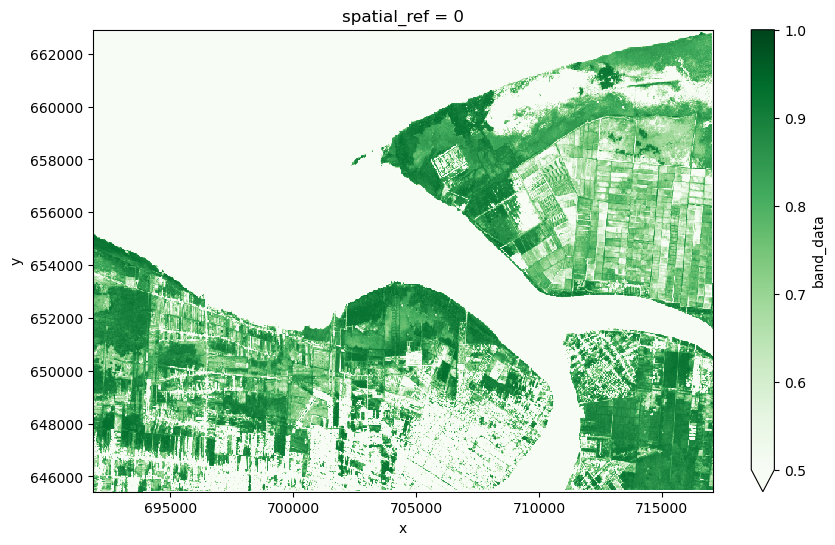

In [152]:
ndvi.plot.imshow(figsize=(10,6),cmap = 'Greens',vmin=0.5,vmax=1)

### Convert vector to raster

To create a raster with the vector "burned in", we can use the `rasterio.features.rasterize` function. This expects a list of (shape, value) tuples, and an output image shape and transform. Here, we will create a new raster image with the same shape and extent as the DEM above. And we first take a buffer of the river lines:

In [ ]:
import rasterio.features

In [ ]:
segments_buffered = segments.geometry.buffer(100)
img = rasterio.features.rasterize(
    segments_buffered, 
    out_shape=clipped.shape, 
    transform=clipped.rio.transform())

In [ ]:
img

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(img)
ax1.imshow(clipped.values - img*20, vmin=0, cmap="terrain") # just as an example
fig.tight_layout()

# Raster statistieken

The **rasterstats** package provides methods to calculate summary statistics of geospatial raster datasets based on vector geometries (https://github.com/perrygeo/python-rasterstats)

Under c

To illustrate this, we are reading a raster file with elevation data of the full world (the file contains a single band for the elevation, save the file in the `data` subdirectory; [download link](https://www.eea.europa.eu/data-and-maps/data/world-digital-elevation-model-etopo5/zipped-dem-geotiff-raster-geographic-tag-image-file-format-raster-data/zipped-dem-geotiff-raster-geographic-tag-image-file-format-raster-data/at_download/file)):

In [ ]:
countries = geopandas.read_file("./data/ne_110m_admin_0_countries.zip")
cities = geopandas.read_file("./data/ne_110m_populated_places.zip")

In [ ]:
dem_geotiff = "data/DEM_geotiff/alwdgg.tif"

In [ ]:
img = xr.open_dataarray(dem_geotiff).sel(band=1).plot.imshow(cmap="terrain", figsize=(10, 4), )
img.axes.set_aspect("equal")

Given this raster of the elevation, we might want to know the elevation at a certain location or for each country.
For the countries example, we want to extract the pixel values that fall within a country polygon, and calculate a statistic for it, such as the mean or the maximum.

Such functionality to extract information from a raster for given vector data is provided by the rasterstats package.

In [ ]:
import rasterstats

For extracting the pixel values for polygons, we use the `zonal_stats` function, passing it the GeoSeries, the path to the raster file, and the method to compute the statistics.

In [ ]:
result = rasterstats.zonal_stats(countries.geometry, dem_geotiff,
                                 stats=['min', 'mean', 'max'], 
                                 nodata=-999)

The results can be assigned to new columns:

In [ ]:
countries[['min', 'max', 'mean']] = pd.DataFrame(result)

In [ ]:
countries.head()

And then we can sort by the average elevation of the country:

In [ ]:
countries.sort_values('mean', ascending=False).head()

For points, a similar function called `point_query` can be used (specifying the interpolation method):

In [ ]:
cities["elevation"] = rasterstats.point_query(cities.geometry, 
                                              dem_geotiff, interpolate='bilinear',
                                              nodata=-999)

In [ ]:
cities.sort_values(by="elevation", ascending=False).head()

Thanks to https://geohackweek.github.io/raster/04-workingwithrasters/ for the inspiration